# Project Library

## Data Frame Column Selector

In [1]:
from numpy import setdiff1d
from pandas import DataFrame, Series


class Columns:
    def __init__(self,
                 dataset: DataFrame,
                 target: str = '',
                 exclude_cols: tuple[str, ...] = (),
                 ordinal_cols: tuple[str, ...] = ()
         ):
        """
        Parses dataset and extracts major groupings of columns.
        :param dataset: The pandas DataFrame which stores *all* columns and values
        :param target: The target value to predict
        :param exclude_cols: Any columns to be excluded
        :param ordinal_cols: Any ordinal columns
        """
        exclude_cols += (target,)
        self.target_col = target
        self.excluded_cols = exclude_cols

        self.raw_cols = dataset.columns
        self.raw_numerical_cols = dataset.select_dtypes(exclude='object').columns
        self.raw_categorical_cols = dataset.select_dtypes(include='object').columns
        self.raw_ordinal_cols = ordinal_cols
        self.raw_misc_categorical_cols = self.setdiff(self.raw_categorical_cols, self.raw_ordinal_cols)

        self.cols = self.setdiff(self.raw_cols, self.excluded_cols)
        self.numerical_cols = self.setdiff(self.raw_numerical_cols, self.excluded_cols)
        self.categorical_cols = self.setdiff(self.raw_categorical_cols, self.excluded_cols)
        self.ordinal_cols = self.setdiff(self.raw_ordinal_cols, self.excluded_cols)
        self.misc_categorical_cols = self.setdiff(self.raw_misc_categorical_cols, self.excluded_cols)

        self.training_cols = self.setdiff(self.cols, self.target_col)

    @staticmethod
    def setdiff(*arrays):
        if len(arrays) < 2:
            raise ValueError('Error! There must be at least 2 arrays')
        base = arrays[0]
        for index in range(1, len(arrays)):
            base = setdiff1d(base, arrays[index])
        return base


## Pipeline

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures


def get_numerical_pipeline(polynomial_features=False):
    numerical_transforms = [
        ('knn_imputer', KNNImputer(n_neighbors=15, weights='distance')),
        ('std_scaler', MinMaxScaler())
    ]
    if polynomial_features:
        numerical_transforms.insert(1, ('poly_features', PolynomialFeatures(degree=2)))
    return Pipeline(numerical_transforms)

def get_categorical_ordinal_pipeline():
    return Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder()),
    ('std_scaler', MinMaxScaler()),
])

def get_categorical_misc_pipeline():
    return Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot_encoder', OneHotEncoder(
        handle_unknown='infrequent_if_exist',
        min_frequency=0.05,
        sparse_output=False,
    )),
])


def get_pipeline(columns: Columns, polynomial_features=False):
    transformers = []
    if len(columns.numerical_cols) != 0:
        transformers.append(('numerical_columns', get_numerical_pipeline(polynomial_features=polynomial_features), columns.numerical_cols))
    if len(columns.ordinal_cols) != 0:
        transformers.append(('ordinal_columns', get_categorical_ordinals_pipeline(), columns.ordinal_cols))
    if len(columns.misc_categorical_cols) != 0:
        transformers.append(('misc_categorical_columns', get_categorical_misc_pipeline(), columns.misc_categorical_cols))
    return ColumnTransformer(
        transformers,
        verbose_feature_names_out=False,
        remainder='passthrough'
    )


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Manipulation

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

def get_raw_data(max_essays, max_sequences):
    raw_logs = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv')
    raw_scores = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv')
    selected_ids = raw_scores['id'].sort_values().head(max_essays)
    selected_logs = raw_logs[ (raw_logs['event_id'] <= max_sequences) & (raw_logs['id'].isin(selected_ids)) ]
    selected_logs.sort_values('id')
    selected_scores = raw_scores[ raw_scores['id'].isin(selected_ids) ]
    return selected_logs, selected_scores

def split_data(logs, scores, split=0.85, stratify=None, random_state=42):
    left_scores, right_scores = train_test_split(scores, train_size=split, shuffle=True, stratify=stratify, random_state=random_state)
    left_logs = logs[logs['id'].isin(left_scores['id'])]
    right_logs = logs[logs['id'].isin(right_scores['id'])]
    sort_logs = lambda df: df.sort_values(by=['id', 'event_id'])
    sort_scores = lambda df: df.sort_values(by='id')
    return sort_logs(left_logs), sort_scores(left_scores), sort_logs(right_logs), sort_scores(right_scores)

def get_agg_data(left_ids, right_ids):
    agg_data = pd.read_csv('/kaggle/input/aggregate-data/aggregate_train_logs.csv')
    return agg_data[agg_data['id'].isin(left_ids)], agg_data[agg_data['id'].isin(right_ids)]

def pad_seq(data):
    data_seq = [group.drop(['id', 'event_id'], axis=1) for _, group in data.groupby('id', sort=False)]
    return pad_sequences(
        data_seq, maxlen=max_sequences, padding='post', truncating='post', value=0, dtype='float32'
    )

## Model Selection

In [4]:
from numpy import mean, std, median, sqrt, power
from pandas import read_csv, DataFrame
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
import pickle
from sklearn.base import BaseEstimator


class EvaluatedModel:
    def __init__(self, name: str, model: BaseEstimator, evaluation, scoring: str):
        self.name = name
        self.scores = evaluation
        self.model = model
        self.scoring = scoring

    def __str__(self):
        return f'Name: {self.name}\nModel: {self.model}\nEvaluation: {self.scores}'

def save_obj(obj, name: str):
    with open(f'/kaggle/working/{name}', 'wb') as obj_file:
        pickle.dump(obj, obj_file)


def load_obj(name: str):
    with open(f'/kaggle/working/{name}', 'rb') as obj_file:
        return pickle.load(obj_file)

def _get_evaluation_generic_(eval_model: EvaluatedModel, name: str, transform_scores: callable):
    scores = transform_scores(eval_model.scores)
    return f'''
            MODEL: {eval_model.model}
            RAW {name}: {scores}
            MEAN {name}: {mean(scores)}
            STD {name}: {std(scores)}
            MEDIAN {name:} {median(scores)}
    '''


def _get_evaluation_(eval_model: EvaluatedModel):
    match eval_model.scoring:
        case 'neg_mean_squared_error':
            return _get_evaluation_generic_(eval_model, 'Root MSE', lambda i: sqrt(-i))
        case 'f1':
            return _get_evaluation_generic_(eval_model, 'F1', lambda i: i)
        case _:
            raise ValueError(f'Error! The {eval_model.scoring} metric is not supported.')


def random_search(model, param_list, training_data, training_labels, scoring):
    rs = RandomizedSearchCV(model, param_list, cv=5, scoring=scoring, n_iter=50, n_jobs=-1,
                            random_state=42)
    rs.fit(training_data, training_labels)
    return rs


def grid_search(model, param_list, training_data, training_labels, scoring):
    gs = GridSearchCV(model, param_list, cv=5, scoring=scoring)
    gs.fit(training_data, training_labels)
    return gs

def find_best_params(model, param_list, search_type, tr_labels, tr_set, scoring):
    if search_type == 'grid':
        best_params = grid_search(model, param_list, tr_set, tr_labels, scoring=scoring).best_params_
    elif search_type == 'random':
        best_params = random_search(model, param_list, tr_set, tr_labels, scoring=scoring).best_params_
    else:
        raise ValueError('Error! That is not a valid search type.')
    return best_params

def evaluate_model(model, tr_set, tr_labels, param_list=None,
                   search_type='grid', scoring='neg_mean_squared_error', name=None):
    parameterized_model = model
    if param_list:
        best_params = find_best_params(model, param_list, search_type, tr_labels, tr_set, scoring=scoring)
        print(best_params)
        parameterized_model = model.__class__(**best_params)
    scores = cross_val_score(parameterized_model, tr_set, tr_labels, scoring=scoring, cv=5)
    evaluated_model = EvaluatedModel(name, parameterized_model, scores, scoring=scoring)
    print(_get_evaluation_(evaluated_model))
    if name:
        save_eval_model(evaluated_model)
    return parameterized_model


## Gradient Callback

In [ ]:
import tensorflow as tf
class PrintGradients(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PrintGradients, self).__init__()
        self.prev_weights = None

    def on_epoch_begin(self, epoch, logs=None):
        # Store the current weights at the beginning of each epoch
        self.prev_weights = [tf.identity(w) for w in self.model.get_weights()]

    def on_epoch_end(self, epoch, logs=None):
        # Get the current model
        model = self.model

        # Calculate the absolute change in weights per layer
        current_weights = model.get_weights()
        if self.prev_weights is not None:
            weight_changes = [np.abs(c - p) for c, p in zip(current_weights, self.prev_weights)]

            # Aggregate the changes per layer
            aggregate_changes = [np.sum(change) for change in weight_changes]

            # Print the aggregate absolute change in weights per layer
            print("Aggregate absolute change in weights per layer:")
            for layer, change in enumerate(aggregate_changes):
                print(f"Layer {layer + 1}: {change}")
        else:
            print("No previous weights to compare.")

# Data Processing

## Sequential Data

In [6]:
from keras import layers, Model, optimizers
from tensorflow.keras.utils import pad_sequences, set_random_seed
from sklearn import set_config

set_config(transform_output='pandas')
set_random_seed(121)
rs = 42
max_essays = 2000
max_sequences = 1500

raw_data, raw_labels = get_raw_data(max_essays=max_essays, max_sequences=max_sequences)
print('Loaded Sequential Data')
raw_tr_set, tr_labels, raw_ts_set, ts_labels = split_data(raw_data, raw_labels, split=0.85, stratify=raw_labels['score'])
print('Split Sequential Data')

cols = Columns(raw_tr_set, exclude_cols=('id', 'event_id'))
pipeline = get_pipeline(cols)
tr_set = pipeline.fit_transform(raw_tr_set)
ts_set = pipeline.transform(raw_ts_set)
print('Transformed Sequential Data')

tr_pad_seqs = pad_seq(tr_set)
ts_pad_seqs = pad_seq(ts_set)
print('Generated Padded Sequential Data')

Loaded Sequential Data
Split Sequential Data
Transformed Sequential Data
Generated Padded Sequential Data


## Aggregate Data

In [7]:
raw_tr_agg_data, raw_ts_agg_data = get_agg_data(tr_labels['id'], ts_labels['id'])
print('Loaded Aggregate Data')

agg_cols = Columns(raw_tr_agg_data, exclude_cols=('id',))
agg_pipeline = get_pipeline(agg_cols)
tr_agg_data = agg_pipeline.fit_transform(raw_tr_agg_data)
tr_agg_data = tr_agg_data.drop('id', axis=1).to_numpy()

ts_agg_data = agg_pipeline.transform(raw_ts_agg_data)
ts_agg_data = ts_agg_data.drop('id', axis=1).to_numpy()
print('Transformed Aggregate Data')

print(tr_agg_data.shape, tr_pad_seqs.shape, tr_labels.shape)
print(ts_agg_data.shape, ts_pad_seqs.shape, ts_labels.shape)

Loaded Aggregate Data
Transformed Aggregate Data
(1700, 51) (1700, 1500, 21) (1700, 2)
(300, 51) (300, 1500, 21) (300, 2)


## Verify Transformations

In [8]:
def verify_splits():
    test_ids = raw_tr_set['id'].sample(150)
    test_essay_logs = raw_tr_set[raw_tr_set['id'].isin(test_ids)]
    test_raw_essay_logs = raw_data[raw_data['id'].isin(test_ids)]
    assert len(test_essay_logs) == len(test_raw_essay_logs)
    assert test_essay_logs.equals(test_raw_essay_logs)

def verify_stratification(tolerance=0.002):
    percent_scores = lambda df: df['score'].value_counts(normalize=True).sort_index()
    for (raw_p, tr_p, ts_p) in zip(percent_scores(raw_labels), percent_scores(tr_labels), percent_scores(ts_labels)):
        assert abs(raw_p - tr_p) <= tolerance
        assert abs(raw_p - ts_p) <= tolerance
    
verify_splits()
verify_stratification()
print("All tests passed")

All tests passed


# Data Visualization

## TSNE

In [9]:
from sklearn.manifold import TSNE

tsne_2d_model = TSNE(n_components=2, learning_rate='auto', early_exaggeration=60, random_state=42, perplexity=40, n_iter=1500, n_jobs=-1)
tsne_2d_data = tsne_2d_model.fit_transform(tr_agg_data)

tsne_3d_model = TSNE(n_components=3, learning_rate='auto', early_exaggeration=60, random_state=42, perplexity=40, n_iter=1500, n_jobs=-1)
tsne_3d_data = tsne_3d_model.fit_transform(tr_agg_data)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px

def plot_interactive_2d_tsne(tsne_2d, labels):
    # Plot using Plotly Express
    fig = px.scatter(tsne_2d, x=0, y=1, color=labels,
                     color_continuous_scale='magma', labels={'color': 'Target'})

    # Customize the layout if needed
    fig.update_layout(title='2D t-SNE Plot',
                      xaxis_title='t-SNE Component 1',
                      yaxis_title='t-SNE Component 2')

    # Show the plot
    fig.show()
    fig.write_html('/kaggle/working/2D-TSNE.html')

    

def plot_interactive_3d_tsne(tsne_3d, labels):
    """
    Generate an interactive 3D t-SNE plot.
    Parameters:
    - tsne_3d (numpy.ndarray): 3D t-SNE coordinates
    - labels (numpy.ndarray): labels for color-coding

    Returns:
    - None (displays the plot interactively).
    """
    scatter = go.Scatter3d(
        x=tsne_3d[:, 0],
        y=tsne_3d[:, 1],
        z=tsne_3d[:, 2],
        mode='markers',
        marker=dict(
            size=8,
            color=labels,
            colorscale='magma',
            opacity=0.8
        ),
        text=['Label: {:.1f}'.format(label) for label in labels]
    )

    layout = go.Layout(
        scene=dict(
            xaxis=dict(title='Comp. 1'),
            yaxis=dict(title='Comp. 2'),
            zaxis=dict(title='Comp. 3')
        ),
        title='t-SNE'
    )

    fig = go.Figure(data=[scatter], layout=layout)

    # Show the interactive plot
    fig.show()
    fig.write_html('/kaggle/working/3D-TSNE.html')
    

plot_interactive_2d_tsne(tsne_2d_data, tr_labels['score'])
plot_interactive_3d_tsne(tsne_3d_data, tr_labels['score'])

## Essay Distribution

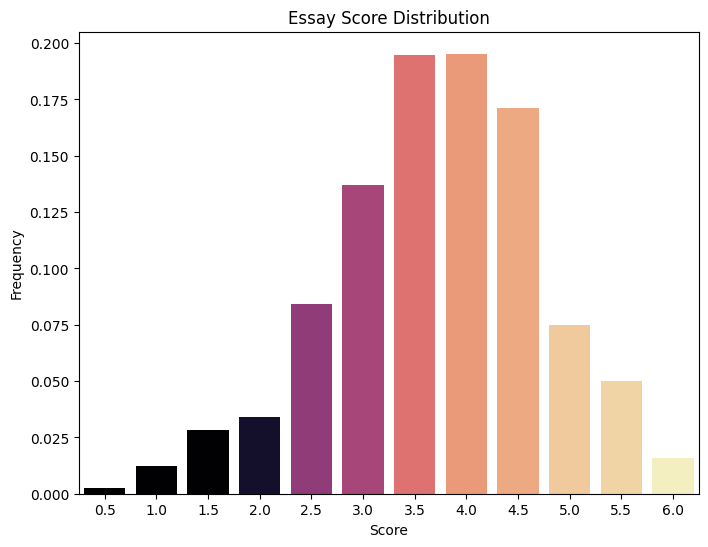

<Figure size 640x480 with 0 Axes>

In [11]:
import seaborn as sns
import numpy as np

score_freq_distrib = tr_labels['score'].value_counts()
colors = sns.color_palette("magma_r", as_cmap=True)
plt.figure(figsize=(8, 6))
sns.barplot(x=score_freq_distrib.index, y=score_freq_distrib.values / len(tr_labels['score']), palette=colors(score_freq_distrib.values))
plt.title('Essay Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()
plt.savefig('/kaggle/working/essay_score_distrib.png')

# Model Training:

## Baseline Model Training: 

### Suport Vector Regressor

In [12]:
from sklearn.svm import SVR
import numpy as np

svr_params = {
    'C': np.random.uniform(0, 100, 50),
    'epsilon': np.random.uniform(0, 1, 20)
}
svr = SVR(kernel='rbf')
evaluate_model(svr, tr_agg_data, tr_labels['score'], param_list=svr_params, search_type='random')
save_obj(svr, name='SVR: rmse=?')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


{'epsilon': 0.020600152077816736, 'C': 3.0753668387938915}

            MODEL: SVR(C=3.0753668387938915, epsilon=0.020600152077816736)
            RAW Root MSE: [0.64391825 0.62904756 0.69555766 0.65222935 0.66456156]
            MEAN Root MSE: 0.657062876519165
            STD Root MSE: 0.02244584781683431
            MEDIAN Root MSE 0.6522293462460655
    


### Random Forest Regressor

In [13]:
from sklearn.ensemble import RandomForestRegressor
rfr_params = { 
    'n_estimators': [25] + np.random.randint(10, 100, 20),
    'min_samples_split': [8] + np.random.randint(2, 100, 10),
    'min_samples_leaf': [5] + np.random.randint(1, 100, 10),
    'max_depth': [30] + np.random.randint(5, 100, 10),
    'n_jobs': [-1],
    'random_state': [42]
}
rfr = RandomForestRegressor()
evaluate_model(rfr, tr_agg_data, tr_labels['score'], param_list=rfr_params, search_type='random')
save_obj(rfr, name='RandomForestRegressor: rmse=?')

{'random_state': 42, 'n_jobs': -1, 'n_estimators': 83, 'min_samples_split': 16, 'min_samples_leaf': 17, 'max_depth': 68}

            MODEL: RandomForestRegressor(max_depth=68, min_samples_leaf=17, min_samples_split=16,
                      n_estimators=83, n_jobs=-1, random_state=42)
            RAW Root MSE: [0.65113523 0.62760873 0.70333644 0.66768163 0.65837886]
            MEAN Root MSE: 0.6616281792401294
            STD Root MSE: 0.024715202029834737
            MEDIAN Root MSE 0.6583788582611028
    


## Sci-Kit Learn Model Training:

In [14]:
# MODELS:
from sklearn.linear_model import *
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

In [15]:
rs = {'random_state': 42}
models = [
   # Linear Models:
   LinearRegression(),
   PassiveAggressiveRegressor(**rs),
   Ridge(**rs),
   Lasso(**rs),
   ElasticNet(**rs),
   BayesianRidge(),
   SGDRegressor(**rs),

   # Trees:
   DecisionTreeRegressor(**rs),
   ExtraTreeRegressor(**rs),

   # Neighbors:
   KNeighborsRegressor(),

   # Gauss:
   GaussianProcessRegressor(**rs),

   # Ensemble:
   RandomForestRegressor(**rs),
   ExtraTreesRegressor(**rs),
   HistGradientBoostingRegressor(**rs),
   GradientBoostingRegressor(**rs),
   XGBRegressor(**rs),
   LGBMRegressor(force_col_wise=True, **rs),
   BaggingRegressor(**rs),
   BaggingRegressor(estimator=XGBRegressor(**rs), n_estimators=7, n_jobs=-1),
   BaggingRegressor(estimator=LGBMRegressor(**rs), n_estimators=7, n_jobs=-1),
   BaggingRegressor(estimator=ExtraTreesRegressor(**rs), n_estimators=7, n_jobs=-1),
   VotingRegressor(estimators=[
      ('extra_trees', ExtraTreesRegressor(**rs)),
      ('lgbm1', LGBMRegressor(force_col_wise=True, **rs)),
      ('lgbm2', LGBMRegressor(force_col_wise=True, **rs)),
      ('xgb', XGBRegressor(**rs))], n_jobs=-1),
   StackingRegressor(estimators=[
      ('extra_trees', ExtraTreesRegressor(**rs)),
      ('lgbm1', LGBMRegressor(force_col_wise=True, **rs)),
      ('lgbm2', LGBMRegressor(force_col_wise=True, **rs)),
      ('xgb', XGBRegressor(**rs))], n_jobs=-1),

   # Neural Network:
   MLPRegressor(**rs)
]

for model in models:
  # ModelEvaluation: wrapper around cross validation, grid/rand searches, summarization, and saving methods
  eval_model = evaluate_model(model, tr_agg_data, tr_labels['score'])


            MODEL: LinearRegression()
            RAW Root MSE: [0.63097339 0.65016674 0.70826184 0.67682121 0.65612892]
            MEAN Root MSE: 0.6644704214118746
            STD Root MSE: 0.026330427538618625
            MEDIAN Root MSE 0.6561289234166326
    

            MODEL: PassiveAggressiveRegressor(random_state=42)
            RAW Root MSE: [0.9509456  0.71062564 0.74163102 0.72803146 1.15551543]
            MEAN Root MSE: 0.8573498292501049
            STD Root MSE: 0.1728033362292128
            MEDIAN Root MSE 0.7416310176248236
    

            MODEL: Ridge(random_state=42)
            RAW Root MSE: [0.63844386 0.64606794 0.71307396 0.66979712 0.66540879]
            MEAN Root MSE: 0.6665583333548403
            STD Root MSE: 0.02602227731601755
            MEDIAN Root MSE 0.665408790339093
    

            MODEL: Lasso(random_state=42)
            RAW Root MSE: [1.02837789 0.9899454  1.04298432 1.03686196 1.01174012]
            MEAN Root MSE: 1.0219819383301687
  

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RidgeCV was fitted without feature names

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RidgeCV was fitted without feature names

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RidgeCV was fitted without feature names

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:



            MODEL: StackingRegressor(estimators=[('extra_trees',
                               ExtraTreesRegressor(random_state=42)),
                              ('lgbm1',
                               LGBMRegressor(force_col_wise=True,
                                             random_state=42)),
                              ('lgbm2',
                               LGBMRegressor(force_col_wise=True,
                                             random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping...
                                            gpu_id=None, grow_policy=None,
            

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.




            MODEL: MLPRegressor(random_state=42)
            RAW Root MSE: [0.64812014 0.65085138 0.71363455 0.66317455 0.66969583]
            MEAN Root MSE: 0.6690952903100912
            STD Root MSE: 0.023630314969853804
            MEDIAN Root MSE 0.6631745508633728
    


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



## Sci-Keras Experimental Models:
Sci-keras allows you to wrap neural network models built in TensorFlow and Keras in an Sklearn interface. This allows them to be used in ensemble models and in evaluation functions like `cross_val_score`. 

In [16]:
import sklearn as sklearn

def evaluate(model, data=ts_agg_data, labels=ts_labels['score']):
    predictions = model.predict(data)
    mse = sklearn.metrics.mean_squared_error(labels, predictions)
    print(np.sqrt(mse))

In [17]:
!pip install keras-tcn
!pip install scikeras

In [18]:
# IMPORTS:
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.metrics as metrics
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.regularizers as regularizers
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from functools import partial

from scikeras.wrappers import KerasRegressor
from sklearn.linear_model import *
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

### Dense Model:

In [19]:
def DenseResBlock(shortcut, units, activation, dropout=0):
    DefaultDense = partial(layers.Dense, units=units)
    l = DefaultDense()(shortcut)
    l = layers.BatchNormalization()(l)
    l = layers.Activation(activation)(l)
    l = layers.Dropout(dropout)(l)
    
    l = DefaultDense()(l)
    l = layers.BatchNormalization()(l)
    l = layers.Dropout(dropout)(l)

    if shortcut.shape != (None, units):
        shortcut = layers.Dense(units=units)(shortcut)
    
    l = layers.Activation(activation)(l + shortcut)
    return l

def build_dense_model(dense_agg_data, n_dense=15, units=100, dropout=0, activation='tanh'):
    agg_inp = layers.Input(shape=dense_agg_data.shape[1:])
    d = agg_inp
    for _ in range(n_dense):
        d = DenseResBlock(d, units=units, activation=activation, dropout=dropout)
    output = layers.Dense(units=1, activation=lambda x: tf.sigmoid(x)*6)(d)

    model = keras.Model(inputs=[agg_inp], outputs=[output])
    return model

### Convolutional Model:

In [20]:
def ConvResBlock(shortcut, activation, filters, kernel_size, **kwargs):
    DefaultConv1D = partial(layers.Conv1D, filters=filters, kernel_size=kernel_size, padding='same', **kwargs)
    l = DefaultConv1D()(shortcut)
    l = layers.BatchNormalization()(l)
    l = layers.Activation(activation)(l)

    l = DefaultConv1D()(l)
    l = layers.BatchNormalization()(l)
        
    l = layers.Activation(activation)(l + shortcut)
    return l

def build_conv_model(conv_seq_input, conv_activation='relu', n_conv_layers=4,
                     filters=128, kernel_size=16):
    seq_inp = layers.Input(shape=conv_seq_input.shape[1:])
    r = layers.Conv1D(kernel_size=kernel_size, filters=filters, padding='valid')(seq_inp)
    for _ in range(n_conv_layers):
        r = ConvResBlock(r, conv_activation, filters, kernel_size)

    r = DenseResBlock(r, units=100, activation='relu', dropout=0)
    r = DenseResBlock(r, units=100, activation='relu', dropout=0)
    
    output = layers.Dense(units=1, activation=lambda x: tf.sigmoid(x)*6)(r)

    model = keras.Model(inputs=[seq_inp], outputs=[output])
    return model

### Temporal Convolutional Model:

In [21]:
from tcn import TCN

def build_tcn_model(tcn_seqs, activation='relu', dropout=0.05):
    return keras.Sequential([
        TCN(
            input_shape=tcn_seqs.shape[1:],
            nb_filters=8,
            kernel_size=32,
            nb_stacks=1,
            dilations=(1, 2, 4, 8),
            padding='causal',
            use_skip_connections=True,
            dropout_rate=dropout,
            return_sequences=True,
            activation=activation,
            kernel_initializer='he_normal',
            use_batch_norm=True,
        ),
        TCN(
            nb_filters=64,
            kernel_size=16,
            nb_stacks=1,
            dilations=(1, 2, 4, 8),
            padding='causal',
            use_skip_connections=True,
            dropout_rate=dropout,
            return_sequences=False,
            activation=activation,
            kernel_initializer='he_normal',
            use_batch_norm=True,
        ),
        layers.Dense(units=1, activation=lambda x: tf.sigmoid(x)*6)
    ])

### Keras to Sklearn Model
This function wraps an sklearn interface around a keras NN. 

In [22]:
def build_keras_model(build_model_function, learning_rate=0.008, epochs=50, **kwargs):
    return KerasRegressor(
        model=build_model_function, 
        loss='mse', 
        optimizer=optimizers.Adam(learning_rate=learning_rate, amsgrad=True),
        metrics=[
            tf.keras.metrics.RootMeanSquaredError()
        ],
        validation_split=0.15,
        epochs=epochs,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-9)
        ],
        **kwargs
    )

### Stacking Models

In [103]:
# KERAS:
keras_dense_model = build_keras_model(build_dense_model, learning_rate=0.005, dense_agg_data=tr_agg_data, units=100, n_dense=5, dropout=0.05, epochs=30)

# SKLEARN:
sklearn_extra_trees_model1 = ExtraTreesRegressor(min_samples_leaf=13, max_leaf_nodes=51, n_jobs=-1, random_state=42)
sklearn_random_forest_model = RandomForestRegressor()

sklearn_kn_model = KNeighborsRegressor(n_neighbors=7, leaf_size=30, p=1, n_jobs=-1)

sklearn_lgbm_model1 = LGBMRegressor(n_estimators=150, num_leaves=13, learning_rate=0.1, random_state=42)
sklearn_xgb_model = XGBRegressor()
sklearn_gboost_model = GradientBoostingRegressor(n_estimators=30, max_depth=4, learning_rate=0.12, random_state=42)
sklearn_svr_model = SVR(**{'epsilon': 0.020600152077816736, 'C': 3.0753668387938915})

## Linear Models:
sklearn_lin_reg_model = LinearRegression()
sklearn_ridge_model = Ridge()
sklearn_bayesian_ridge_model = BayesianRidge()

In [ ]:
full_stacking_model = StackingRegressor(
    estimators=[
        ('keras_dense', keras_dense_model),
        
        ('sk_extra_trees1', sklearn_extra_trees_model1),
        ('sk_kn', sklearn_kn_model),
        ('sk_lgbm1', sklearn_lgbm_model1),
        ('sk_gboost', sklearn_gboost_model),
        
        ('sk_lin_reg', sklearn_lin_reg_model),
        ('sk_ridge', sklearn_ridge_model),
        ('sk_bayesian_ridge', sklearn_bayesian_ridge_model),
        ('sk_lasso', sklearn_lasso_model),
    ],
    final_estimator=DecisionTreeRegressor()
)
evaluate_model(full_stacking_model, tr_agg_data, tr_labels['score'])

**Image of final score**:
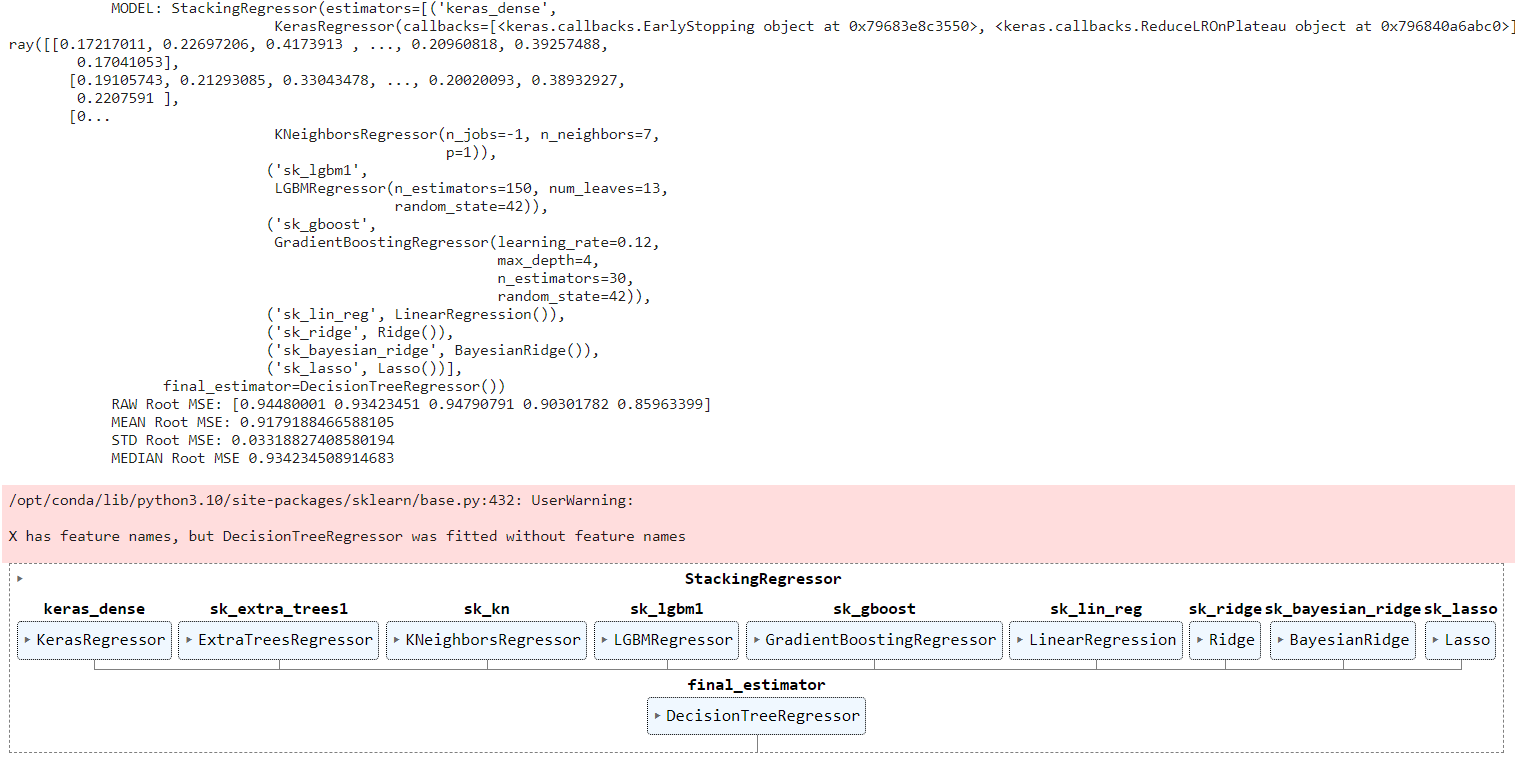

In [105]:
stacking_model = StackingRegressor(
    estimators=[
        ('sk_extra_trees', sklearn_extra_trees_model1),
        ('sk_lgbm', sklearn_lgbm_model1),
        ('sk_lin_reg', sklearn_lin_reg_model),
        ('sk_ridge', sklearn_ridge_model),
        ('sk_bayesian_ridge', sklearn_bayesian_ridge_model),
        ('sk_xgb_model', sklearn_xgb_model),
        ('sk_svr', sklearn_svr_model),
        ('sk_rand_forest', sklearn_random_forest_model),
        ('sk_gboost_model', sklearn_gboost_model),
    ]
)
evaluate_model(stacking_model, tr_agg_data, tr_labels['score'])

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RidgeCV was fitted without feature names

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RidgeCV was fitted without feature names

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RidgeCV was fitted without feature names

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RidgeCV was fitted without feature names




            MODEL: StackingRegressor(estimators=[('sk_extra_trees',
                               ExtraTreesRegressor(max_leaf_nodes=51,
                                                   min_samples_leaf=13,
                                                   n_jobs=-1,
                                                   random_state=42)),
                              ('sk_lgbm',
                               LGBMRegressor(n_estimators=150, num_leaves=13,
                                             random_state=42)),
                              ('sk_lin_reg', LinearRegression()),
                              ('sk_ridge', Ridge()),
                              ('sk_bayesian_ridge', BayesianRidge()),
                              ('sk_xgb_model',
                               XGBRegressor(base_score=None, boos...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                 

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RidgeCV was fitted without feature names



StackingRegressor(estimators=[('sk_extra_trees',
                               ExtraTreesRegressor(max_leaf_nodes=51,
                                                   min_samples_leaf=13,
                                                   n_jobs=-1,
                                                   random_state=42)),
                              ('sk_lgbm',
                               LGBMRegressor(n_estimators=150, num_leaves=13,
                                             random_state=42)),
                              ('sk_lin_reg', LinearRegression()),
                              ('sk_ridge', Ridge()),
                              ('sk_bayesian_ridge', BayesianRidge()),
                              ('sk_xgb_model',
                               XGBRegressor(base_score=None, boos...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                              ('sk_svr',
                               SVR(C=3.0753668387938915,
                                   epsilon=0.020600152077816736)),
                              ('sk_rand_forest', RandomForestRegressor()),
                              ('sk_gboost_model',
                               GradientBoostingRegressor(learning_rate=0.12,
                                                         max_depth=4,
                                                         n_estimators=30,
                                                         random_state=42))])

## Experimental

In [90]:
from sklearn.model_selection import KFold

def build_wide_model(seq_inputs, agg_inputs):
    tcn = build_tcn_model(seq_inputs, dropout=0.01, activation='tanh')
    dense = build_dense_model(agg_inputs, units=100, activation='tanh', dropout=0)

    concat = layers.Concatenate()([tcn.layers[-2].output, dense.layers[-2].output])
    outer = layers.Dense(units=200, activation='relu')(concat)
    output = layers.Dense(units=1, activation=lambda x: tf.sigmoid(x) * 6)(outer)
    model = keras.Model([tcn.inputs, dense.inputs], output)
    return model

wide_model = build_wide_model(tr_pad_seqs, tr_agg_data)
wide_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.005), 
    loss='mse', 
    metrics=[tf.keras.metrics.RootMeanSquaredError()])
wide_model.fit(
    [tr_pad_seqs, tr_agg_data], 
    tr_labels['score'],
    validation_split=0.15,
    batch_size=20,
    epochs=1000,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-9)
    ]
)

Epoch 1/1000
73/73 [==============================] - 48s 85ms/step - loss: 1.5296 - root_mean_squared_error: 1.2368 - val_loss: 3.2209 - val_root_mean_squared_error: 1.7947 - lr: 0.0050
Epoch 2/1000
73/73 [==============================] - 5s 63ms/step - loss: 0.7954 - root_mean_squared_error: 0.8919 - val_loss: 1.1412 - val_root_mean_squared_error: 1.0683 - lr: 0.0050
Epoch 3/1000
73/73 [==============================] - 5s 63ms/step - loss: 0.6316 - root_mean_squared_error: 0.7947 - val_loss: 0.7444 - val_root_mean_squared_error: 0.8628 - lr: 0.0050
Epoch 4/1000
73/73 [==============================] - 5s 64ms/step - loss: 0.6127 - root_mean_squared_error: 0.7827 - val_loss: 0.5230 - val_root_mean_squared_error: 0.7232 - lr: 0.0050
Epoch 5/1000
73/73 [==============================] - 4s 61ms/step - loss: 0.5742 - root_mean_squared_error: 0.7577 - val_loss: 0.5383 - val_root_mean_squared_error: 0.7337 - lr: 0.0050
Epoch 6/1000
73/73 [==============================] - 4s 61ms/step - 

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures

lin_reg = make_pipeline(KNNImputer(), PolynomialFeatures(degree=2), MinMaxScaler(), Ridge(alpha=6))
evaluate_model(lin_reg, raw_tr_agg_data.drop('id', axis=1), tr_labels['score'])


            MODEL: Pipeline(steps=[('knnimputer', KNNImputer()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('minmaxscaler', MinMaxScaler()), ('ridge', Ridge(alpha=6))])
            RAW Root MSE: [0.6412382  0.63413436 0.69315324 0.65635289 0.66275936]
            MEAN Root MSE: 0.657527610178232
            STD Root MSE: 0.020545196976245107
            MEDIAN Root MSE 0.6563528872822852
    


Pipeline(steps=[('knnimputer', KNNImputer()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('minmaxscaler', MinMaxScaler()), ('ridge', Ridge(alpha=6))])

In [92]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

class ClusteredRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_clusters=10, cluster_regressor=LinearRegression(), cluster_regressor_kwargs: dict = {}):
        self.n_clusters = n_clusters
        self.cluster_regressor = cluster_regressor
        self.cluster_regressor_kwargs = cluster_regressor_kwargs
        self.cluster_models = []
        self.clusterer = KMeans(n_clusters=self.n_clusters, n_init=10)

    def fit(self, X, y):
        # Step 1: Cluster the data
        kmeans = self.clusterer
        clusters = kmeans.fit_predict(X)

        # Step 2: Train a regression model for each cluster
        for cluster in set(clusters):
            cluster_mask = (clusters == cluster)
            model = self.cluster_regressor.__class__(**self.cluster_regressor_kwargs)
            model.fit(X[cluster_mask], y[cluster_mask])
            self.cluster_models.append((cluster, model))
        return self

    def predict(self, X):
        # Predict the cluster for each data point
        clusters = self.clusterer.predict(X)

        # Use the corresponding regression model for each cluster
        predictions = []
        for data_point, cluster in zip(X, clusters):
            model = next((model for c, model in self.cluster_models if c == cluster), None)
            if model is not None:
                prediction = model.predict([data_point])[0]
                predictions.append(prediction)
            else:
                # Handle the case where the cluster is not found
                predictions.append(None)

        return predictions

test = ClusteredRegressor(n_clusters=12, cluster_regressor=SVR(kernel='rbf', C=10), cluster_regressor_kwargs={})
evaluate_model(test, tr_agg_data, tr_labels['score'])
test.fit(tr_agg_data, tr_labels['score'])


            MODEL: ClusteredRegressor(cluster_regressor=SVR(C=10), n_clusters=12)
            RAW Root MSE: [0.67398501 0.66935972 0.73508994 0.72348467 0.70913113]
            MEAN Root MSE: 0.7022100934752571
            STD Root MSE: 0.026295987602947962
            MEDIAN Root MSE 0.7091311320680685
    


ClusteredRegressor(cluster_regressor=SVR(C=10), n_clusters=12)

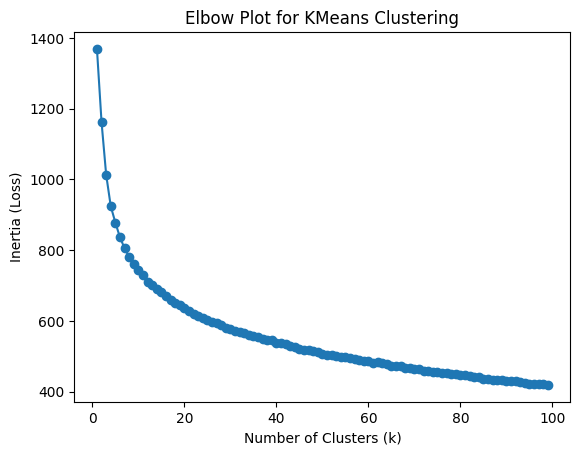

In [33]:
k_values = range(1, 100)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(tr_agg_data)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Plot for KMeans Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Loss)')
plt.show()

In [93]:
evaluate(wide_model, data=[ts_pad_seqs, ts_agg_data])
evaluate(test)
evaluate(stacking_model.fit(tr_agg_data, tr_labels['score']))
evaluate(LinearRegression().fit(tr_agg_data, tr_labels['score']))

10/10 [==============================] - 0s 17ms/step
0.7077006130593981
0.7239548044535716
0.6596473788225563
0.6608291298863497


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RidgeCV was fitted without feature names

